<a href="https://colab.research.google.com/github/Mperorrc/Semi-Supervised-Double-Deep-Q-Networks/blob/main/exp_replay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from gym import Env
from gym.spaces import Discrete, Box

In [ ]:
# !pip install tensorflow==2.11.0
# !pip install keras==2.11.0
# !pip install keras-rl2
# !pip install rl
# !pip install tf-agents
# !pip install --upgrade torch


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# import tensorflow as tf
# import keras
# print(tf.__version__)
# print(keras.__version__)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/DDQN/dataset.xlsx')
df.loc[df.isnull().any(axis=1), 'ALERT'] = 1
df.fillna(0, inplace=True)

In [ ]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,SpO2,HR,PULSE,RESP,ABP2,ABP3,ALERT
0,94.0,71.000000,71.000000,19.0,113.000000,50.000000,0
1,94.0,71.000000,71.000000,19.0,113.000000,50.000000,0
2,94.0,71.000000,71.000000,17.0,113.000000,51.000000,0
3,94.0,71.000000,71.000000,17.0,113.000000,51.000000,0
4,94.0,71.000000,71.000000,17.0,113.000000,50.000000,0
...,...,...,...,...,...,...,...
253021,94.0,111.000000,111.000000,14.0,107.000000,61.000000,0
253022,94.0,111.000000,110.000000,14.0,108.000000,61.000000,0
253023,94.0,111.000000,110.000000,14.0,108.000000,61.000000,0
253024,94.0,111.000000,110.000000,14.0,108.000000,61.000000,0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


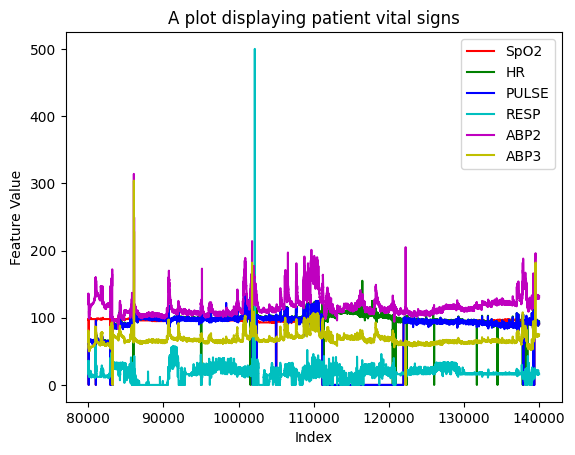

In [ ]:
temp = df[80000:140000]
colors = ['r', 'g', 'b', 'c', 'm', 'y']
for i, (colname, color) in enumerate(zip(temp.columns, colors)):
    plt.plot(temp.index, temp[colname], label=colname, color=color)

plt.xlabel('Index')
plt.ylabel('Feature Value')
plt.legend()
plt.title('A plot displaying patient vital signs')
plt.show()

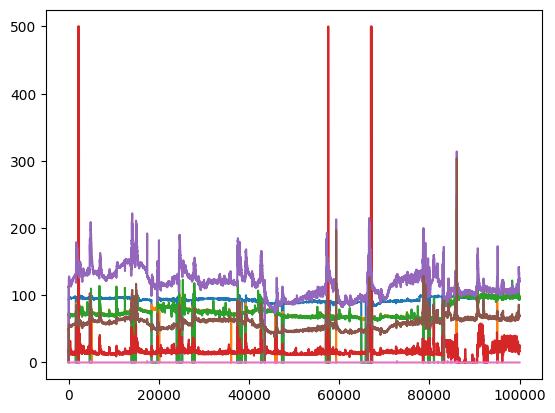

In [ ]:
plt.plot(df[:100000])

In [ ]:
# df = df[:30000]

In [ ]:
df.loc[df['ALERT']==2]=0
print(len(df[df['ALERT']==0]),len(df[df['ALERT']==1]),len(df[df['ALERT']==2]))

228848 24178 0


In [ ]:
target_class_column = 'ALERT'

# Compute correlation between each feature and the target class
correlations = {}
for column in df.columns:
    if column != target_class_column:
        correlation = df[column].corr(df[target_class_column])
        correlations[column] = correlation

# Convert the dictionary to a pandas Series for better visualization
correlation_series = pd.Series(correlations)

# Print or visualize the correlations
print(correlation_series)

SpO2    -0.928728
HR       0.026014
PULSE   -0.858925
RESP     0.075630
ABP2     0.089362
ABP3     0.093886
dtype: float64


In [ ]:
from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# columns = df.columns
# df = pd.DataFrame(scaler.fit_transform(df), columns=columns)

In [ ]:
knn_x = df.iloc[:,:-1]
knn_y = df.iloc[:,-1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df

,SpO2,HR,PULSE,RESP,ABP2,ABP3,ALERT
0,94.0,71.000000,71.000000,19.0,113.000000,50.000000,0
1,94.0,71.000000,71.000000,19.0,113.000000,50.000000,0
2,94.0,71.000000,71.000000,17.0,113.000000,51.000000,0
3,94.0,71.000000,71.000000,17.0,113.000000,51.000000,0
4,94.0,71.000000,71.000000,17.0,113.000000,50.000000,0
...,...,...,...,...,...,...,...
253021,94.0,111.000000,111.000000,14.0,107.000000,61.000000,0
253022,94.0,111.000000,110.000000,14.0,108.000000,61.000000,0
253023,94.0,111.000000,110.000000,14.0,108.000000,61.000000,0
253024,94.0,111.000000,110.000000,14.0,108.000000,61.000000,0


In [ ]:
df = df[:90000]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
split_index = int(0.7 * len(df))
# Splitting the data into training and testing sets
df_train,df_test = df[:split_index],df[split_index:]
df_test = df_test.reset_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


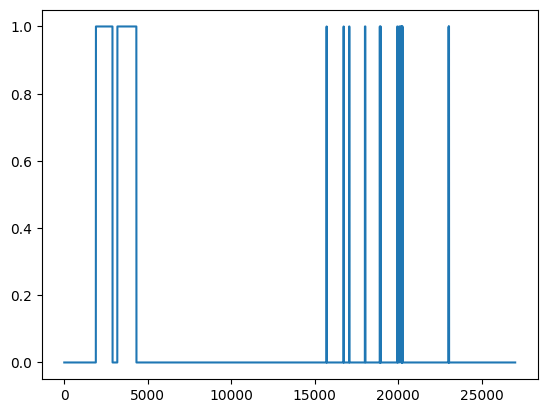

In [ ]:
plt.plot(df_test['ALERT'])

In [ ]:
def get_val(df):
  n1 = (int(len(df[df['ALERT']==0])/len(df[df['ALERT']==1]))-1)
  # n2 = (int(len(df[df['ALERT']==0])/len(df[df['ALERT']==2]))-1)
  num1 = len(df[df['ALERT']==0]) - len(df[df['ALERT']==1])*(1+n1)
  # num2 = len(df[df['ALERT']==0]) - len(df[df['ALERT']==2])*(1+n2)
  print(n1,num1)
  print(len(df[df['ALERT']==2]))
  print(len(df[df['ALERT']==1]))
  print(len(df[df['ALERT']==0]))
  return n1,num1

In [ ]:
def add_rows_false_alarm(row,n1,num1):
    new_rows = []
    num = n1
    if num1 > 0:
      num +=1
      num1 -=1
    for _ in range(num):
        new_row = row.copy()
        new_row['HR'] += np.random.choice([-1, 0, 1])
        new_row['SpO2'] += np.random.choice([-1, 0, 1])
        new_row['PULSE'] += np.random.choice([-1, 0, 1])
        new_rows.append(new_row)
    return new_rows

In [ ]:
def add_rows_true_alarm(row,n2,num2):
    new_rows = []
    num = n2
    if num2 > 0:
      num +=1
      num2 -=1
    for _ in range(num):
        new_row = row.copy()
        if new_row['SpO2'] > 1:
          new_row['SpO2'] += np.random.choice([-1, 0, 1])
        if new_row['HR'] > 50:
          new_row['HR'] += np.random.choice([-1, 0, 1])
        if new_row['PULSE'] >= 60:
          new_row['PULSE'] += np.random.choice([-1, 0, 1])
        new_rows.append(new_row)
    return new_rows

In [ ]:
def oversample(df_train,n1,n2,num1,num2):
  new_df = pd.DataFrame(columns = df_train.columns)
  for index, row in df_train.iterrows():
      if row['ALERT'] == 0:
          new_df = new_df.append(row, ignore_index=True)
      elif row['ALERT']== 1:
          modified_rows = add_rows_false_alarm(row,n1,num1)
          new_df = new_df.append(row, ignore_index=True)
          for new_row in modified_rows:
              new_df = new_df.append(new_row, ignore_index=True)
      else:
          modified_rows = add_rows_true_alarm(row,n2,num2)
          new_df = new_df.append(row, ignore_index=True)
          for new_row in modified_rows:
              new_df = new_df.append(new_row, ignore_index=True)
  new_df = new_df.reset_index()
  return new_df

In [ ]:
# # n1,n2,num1,num2 = get_val(df_train)
# n1,num1 = get_val(df_train)
# df_train = oversample(df_train,n1,0,num1,0)
# # n1,n2,num1,num2 = get_val(df_test)
# # df_test = oversample(df_test,n1,n2,num1,num2)

In [ ]:
# df_train = df_train.sample(frac=1).reset_index(drop=True)

In [ ]:
target_class_column = 'ALERT'

# Compute correlati
# on between each feature and the target class
correlations = {}
for column in df_train.columns:
    if column != target_class_column:
        correlation = df_train[column].corr(df_train[target_class_column])
        correlations[column] = correlation

# Convert the dictionary to a pandas Series for better visualization
correlation_series = pd.Series(correlations)

# Print or visualize the correlations
print(correlation_series)

SpO2    -0.969909
HR       0.169393
PULSE   -0.942143
RESP     0.261728
ABP2     0.230921
ABP3     0.180635
dtype: float64


In [ ]:
x_train,y_train,x_test,y_test = df_train.iloc[:,:-1],df_train.iloc[:,-1],df_test.iloc[:,:-1],df_test.iloc[:,-1]

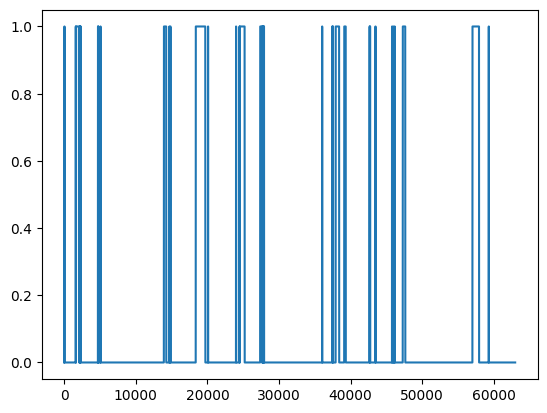

In [ ]:
plt.plot(y_train)

In [ ]:
x_test = x_test.drop(columns=['index'])
x_test

,SpO2,HR,PULSE,RESP,ABP2,ABP3
0,90.0,68.0,67.0,14.0,88.0,44.0
1,90.0,68.0,67.0,14.0,88.0,44.0
2,90.0,68.0,67.0,14.0,88.0,44.0
3,90.0,68.0,67.0,14.0,88.0,44.0
4,90.0,68.0,67.0,14.0,88.0,44.0
...,...,...,...,...,...,...
26996,95.0,96.0,95.0,0.0,100.0,63.0
26997,95.0,96.0,96.0,0.0,101.0,63.0
26998,95.0,96.0,96.0,0.0,100.0,63.0
26999,95.0,97.0,97.0,0.0,100.0,63.0


In [ ]:
# file_path = '/content/drive/MyDrive/Colab Notebooks/DDQN/train.xlsx'
# new_df.to_excel(file_path, index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# # HYPERPARAMTERS

# gamma = 0.99
# batch_size = 64
# buffer_size = 100
# min_replay_size = 90
# epsilon_start = 1.0
# epsilon_end = 0.02
# epsilon_decay = 0.999
# epsilon_steps = 50_000
# target_update_freq = 1000
# alpha = 0.2

In [ ]:
# HYPERPARAMTERS

gamma = 0.99
batch_size = 64
buffer_size = 200
min_replay_size = 100
epsilon_start = 1.0
epsilon_end = 0.02
epsilon_steps = 50_000
target_update_freq = 1000
alpha = 0.001
lr_decay = 0.99

In [ ]:
# x_train_mod = []
# for i in range(lookback,x_train.shape[0]):
#   x_train_mod.append(x_train[i-lookback:i])

# x_test_mod = []
# for i in range(lookback,x_test.shape[0]):
#   x_test_mod.append(x_test[i-lookback:i])

# x_train,y_train,x_test,y_test = np.array(x_train_mod),np.array(y_train),np.array(x_test_mod),np.array(y_test)
x_train,y_train,x_test,y_test = np.array(x_train),np.array(y_train),np.array(x_test),np.array(y_test)

In [ ]:
x_train.shape

(62999, 6)

In [ ]:
target_class_column = 'ALERT'

# Compute correlation between each feature and the target class
correlations = {}
for column in df_train.columns:
    if column != target_class_column:
        correlation = df_train[column].corr(df_train[target_class_column])
        correlations[column] = correlation

# Convert the dictionary to a pandas Series for better visualization
correlation_series = pd.Series(correlations)

# Print or visualize the correlations
print(correlation_series)

SpO2    -0.969909
HR       0.169393
PULSE   -0.942143
RESP     0.261728
ABP2     0.230921
ABP3     0.180635
dtype: float64


# Unsupervised Data

In [ ]:
udf = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/DDQN/mimic2.xlsx')
udf = udf[['spo2','HR','PULSE','RESP','sys','dia']]


In [ ]:
udf = udf.rename(columns = {'spo2':'SpO2','sys':'ABP2','dia':'ABP3'})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# scaler2 = MinMaxScaler()
# udf_cols = udf.columns
# udf = pd.DataFrame(scaler2.fit_transform(udf), columns=udf_cols)

In [ ]:
udf = udf[:200000]

In [ ]:
udf

,SpO2,HR,PULSE,RESP,ABP2,ABP3
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
199995,97,80,79,20,130,67
199996,97,80,80,19,130,67
199997,97,81,80,19,130,67
199998,97,80,80,19,130,67


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


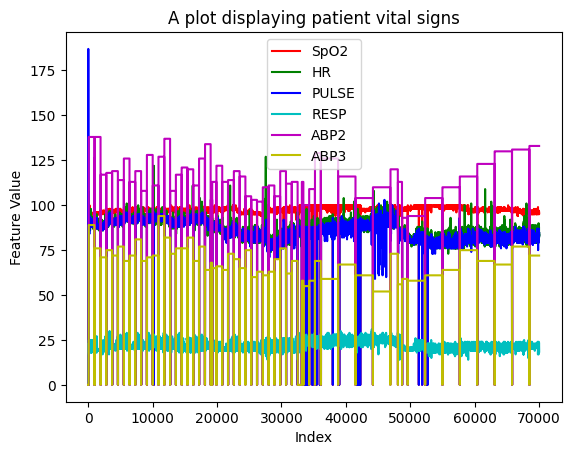

In [ ]:
temp = udf[:70000]
colors = ['r', 'g', 'b', 'c', 'm', 'y']
for i, (colname, color) in enumerate(zip(temp.columns, colors)):
    plt.plot(temp.index, temp[colname], label=colname, color=color)

plt.xlabel('Index')
plt.ylabel('Feature Value')
plt.legend()
plt.title('A plot displaying patient vital signs')
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score

In [ ]:
n_neighbors = int(np.sqrt(knn_x.shape[0]))
if(n_neighbors%2==0):
  n_neighbors += 1
n_neighbors

503

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = n_neighbors, p = 2, metric = 'euclidean')
classifier.fit(knn_x,knn_y)

KNeighborsClassifier(metric='euclidean', n_neighbors=503)

In [ ]:
y_pred = classifier.predict(udf)
# y_pred = classifier.predict(knn_x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
len(y_pred)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


200000

In [ ]:
new_column = pd.DataFrame({'ALERT': y_pred})
udf = pd.concat([udf,new_column],axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


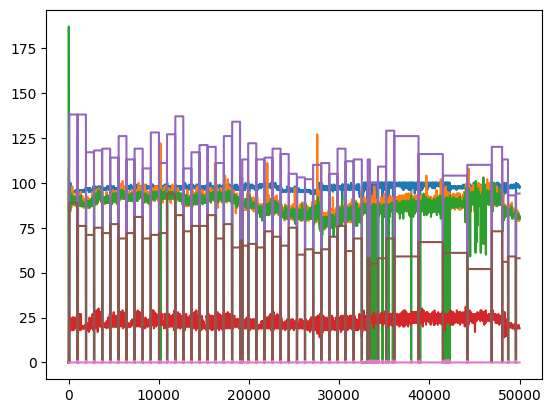

In [ ]:
plt.plot(udf[:50000])

In [ ]:
udf

,SpO2,HR,PULSE,RESP,ABP2,ABP3,ALERT
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
199995,97,80,79,20,130,67,0
199996,97,80,80,19,130,67,0
199997,97,81,80,19,130,67,0
199998,97,80,80,19,130,67,0


In [ ]:
udf_x = udf.iloc[:,:-1]
udf_y = udf.iloc[:,-1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
udf_x = np.array(udf_x)
udf_y = np.array(udf_y)

In [ ]:
x_train = np.concatenate((x_train,udf_x), axis=0)
y_train = np.concatenate((y_train,udf_y),axis=0)

# Environment

In [ ]:
class AnomalyEnv(Env):

    def __init__(self,X_train,y_train):
        self.x_train = x_train
        self.y_train = y_train
        self.action_space = Discrete(2)
        self.observation_space = Box(low=np.zeros(self.x_train.shape[1]), high=np.ones(self.x_train.shape[1]))
        self.index = 0
        self.x_train = np.array(self.x_train)
        self.state = self.x_train[0]
        print(self.state.shape,self.observation_space.shape)

    def step(self, action):
        self.state = self.x_train[self.index]
        reward = 0

        if action == y_train[self.index]:
            reward = 1
        else:
            reward = -1

        self.index += 1
        info = {}

        if self.index == len(self.x_train):
            done = True
        else:
            done = False
            self.state = self.x_train[self.index]

        return self.state, reward, done, info

    def render(self):
        # Implement viz
        pass

    def reset(self):
        self.index=0
        self.state=self.x_train[0]
        return self.state

In [ ]:
env = AnomalyEnv(x_train,y_train)

(6,) (6,)


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [ ]:
env.action_space.sample()

0

In [ ]:

episodes = 2
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        #env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:693
Episode:2 Score:-433


# Model

In [ ]:

from collections import deque
replay_buffer = deque(maxlen=buffer_size)
reward_buffer = deque([0.0],maxlen=100)


In [ ]:
state = env.observation_space.shape
actions = env.action_space.n
print("State ",state," actions ",actions)

State  (6,)  actions  2


In [ ]:
episode_reward = 0.0

In [ ]:
# class Network(nn.Module):
#   def __init__(self,env):
#     super().__init__()
#     ipt_features = env.observation_space.shape
#     print(ipt_features)
#     self.net = nn.Sequential(
#         nn.Conv1d(in_channels=ipt_features[0], out_channels=32, kernel_size=3, padding=1),
#         nn.ReLU(),
#         # nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
#         # nn.ReLU(),
#         nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
#         nn.ReLU(),
#         # nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
#         # nn.ReLU(),
#         nn.Flatten(),
#         nn.Linear(128, 512),
#         nn.Softmax(),
#         nn.Linear(512, env.action_space.n)
#     )

#   def forward(self,x):
#     return self.net(x)

#   def act(self,obs):
#     st_t = torch.as_tensor(obs,dtype=torch.float32)
#     q_values = self(st_t.unsqueeze(0))
#     q_idx = torch.argmax(q_values,dim=1)[0]
#     action = q_idx.detach().item()
#     return action

In [ ]:
class Network(nn.Module):
  def __init__(self,env):
    super(Network,self).__init__()
    ipt_features = np.prod(env.observation_space.shape)
    print(ipt_features)
    self.dense1 = nn.Linear(ipt_features, 128)
    self.dense2 = nn.Linear(128, 256)
    self.lstm = nn.LSTM(128, 128)
    self.dense3 = nn.Linear(256,512)
    self.dense4 = nn.Linear(512, 1024)
    self.dense5 = nn.Linear(512, 2)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = torch.relu(self.dense1(x))
    x = x.view(x.size(0), 1, -1)
    x, _ = self.lstm(x)
    x = torch.relu(self.dense2(x))
    x = torch.relu(self.dense3(x))
    # x = torch.relu(self.dense4(x))
    x = self.dense5(x)
    x = self.sigmoid(x)
    return x

  def act(self,obs):
    st_t = torch.as_tensor(obs,dtype=torch.float32)
    q_values = self(st_t.unsqueeze(0))
    q_values = q_values[:,0,:]
    q_idx = torch.argmax(q_values,dim=1)[0]
    action = q_idx.detach().item()
    return action

In [ ]:
online_net = Network(env)
target_net = Network(env)

6
6


In [ ]:
target_net.load_state_dict(online_net.state_dict())

<All keys matched successfully>

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

optimizer = torch.optim.Adam(online_net.parameters(),lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.99)

# for epoch in range(170):
#     scheduler.step()
#     print(f"Epoch {epoch+1}, Learning Rate: {optimizer.param_groups[0]['lr']}")

In [ ]:
st = env.reset()

In [ ]:
for _ in range(min_replay_size):
  action = env.action_space.sample()
  new_st, reward, done, info = env.step(action)
  buffer_data = (st, action, reward, done, new_st)
  replay_buffer.append(buffer_data)
  st = new_st
  if done:
    st = env.reset()

In [ ]:
st = env.reset()

In [ ]:
print(st)

# Training

In [ ]:

def bellman_eq(rewards_t,dones_t,max_target_net_q):
  return rewards_t + gamma*(1-dones_t)*(max_target_net_q)

In [ ]:
def td_zero(rewards_t,dones_t,max_target_net_q,v_old):
  return v_old + alpha*(rewards_t + gamma*(1-dones_t)*max_target_net_q - v_old)

In [ ]:
network_type = "bellman"

In [ ]:
rews = []
rew = 0

import itertools

for step in range(1*x_train.shape[0]):
  if step < epsilon_steps:
      epsilon = np.interp(step, [0, epsilon_steps], [epsilon_start, epsilon_end])
  else:
      epsilon = epsilon_start
      epsilon_steps += 50_000
  random_sample = random.random()
  if random_sample <= epsilon:
    action = env.action_space.sample()
  else:
    action = online_net.act(st)


  new_st,reward,done,_ = env.step(action)
  episode_reward +=reward
  rew += reward
  buffer_data = (st, action, reward, done, new_st)
  replay_buffer.append(buffer_data)
  st=new_st

  if done:
    st= env.reset()
    reward_buffer.append(episode_reward)
    epsiode_reward=0.0

  buffer_samples = random.sample(replay_buffer,batch_size)
  curr_states = np.asarray([t[0] for t in buffer_samples])
  actions_arr = np.asarray([t[1] for t in buffer_samples])
  rewards = np.asarray([t[2] for t in buffer_samples])
  dones = np.asarray([t[3] for t in buffer_samples])
  next_states = np.asarray([t[4] for t in buffer_samples])

  curr_states_t = torch.as_tensor(curr_states,dtype=torch.float32)
  actions_arr_t = torch.as_tensor(actions_arr,dtype=torch.int64).unsqueeze(-1)
  rewards_t = torch.as_tensor(rewards,dtype=torch.float32)
  dones_t = torch.as_tensor(dones,dtype=torch.float32)
  next_states_t = torch.as_tensor(next_states,dtype=torch.float32)
  # print("Next states shape",next_states_t.shape)
  # print(next_states_t.shape)
  target_net_q = target_net(next_states_t)
  # print("Target_net_q",target_net_q)
  target_net_q = target_net_q[:,0,:]
  max_target_net_q = target_net_q.max(dim=1,keepdims=True)[0]

  # v_old_q = target_net(curr_states_t)
  # v_old_q = v_old_q[:,0,:]
  # max_curr_net_q = v_old_q.max(dim=1,keepdims=True)[0]
  # print(max_target_net_q,(1-dones))
  # print(target)

  # target_net_q = []
  # for i in range(len(next_states)):
  #   q_val = target_net.predict(np.expand_dims(np.expand_dims(next_states[i], axis=0),axis=0))
  #   target_net_q.append(max(q_val[0]))
  # target = rewards + gamma*np.multiply(1-dones,target_net_q)

  online_net_q = online_net(curr_states_t)
  # print(online_net_q)
  # print(online_net_q.shape,online_net_q)
  online_net_max_q = online_net_q.max(dim=2,keepdims=True)[0]
  online_net_max_q = online_net_max_q[:,:,0]
  # print(online_net_max_q.shape,online_net_max_q)
  # print(actions_arr_t.shape,actions_arr_t)

  if network_type == "bellman":
    target = bellman_eq(rewards_t,dones_t,max_target_net_q)
  else :
    target = td_zero(rewards_t,dones_t,max_target_net_q,online_net_max_q)

  action_q_values = torch.gather(input=online_net_max_q, dim=0,index= actions_arr_t)
  loss = nn.functional.mse_loss(action_q_values, target)
  optimizer.zero_grad()
  loss.backward()
  max_norm = 1.0
  nn.utils.clip_grad_norm_(online_net.parameters(), max_norm)
  optimizer.step()

  # if(step%90000 ==0):
  #   scheduler.step()
  if(step%target_update_freq==0):
    target_net.load_state_dict(online_net.state_dict())
    print(episode_reward/(step+1))
    print("reward ",reward)
    print("loss ",loss)
    print("decision ",online_net_q)
  if(step%5000==0):
    print()
    print("STEP : ",step)
    print("avg reward",np.mean(reward_buffer))
  if(step%1000==0):
    rews.append(rew/1000)
    if(rew/1000>0.95):
      break
    rew=0


In [ ]:
print(online_net.state_dict())

# Prediction

In [ ]:
# file_path = '/content/drive/MyDrive/Colab Notebooks/DDQN/ddqn_best.pth'
# torch.save(target_net.state_dict(), file_path)

In [ ]:
target_net.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/DDQN/ssddqn_final.pth'))

<All keys matched successfully>

In [ ]:
# plt.plot(rews)
# print(max(rews))
# rew

In [ ]:
combined_df = np.concatenate((np.array(x_test), knn_x), axis=0)
cy = df = np.concatenate((y_test,knn_y))
print(combined_df.shape,cy.shape)

(280027, 6) (280027,)


In [ ]:
# x_train = np.array(x_train)
x_test_t = torch.as_tensor(np.array(x_test),dtype=torch.float32)
print(x_test_t)

tensor([[ 90.,  68.,  67.,  14.,  88.,  44.],
        [ 90.,  68.,  67.,  14.,  88.,  44.],
        [ 90.,  68.,  67.,  14.,  88.,  44.],
        ...,
        [ 95.,  96.,  96.,   0., 100.,  63.],
        [ 95.,  97.,  97.,   0., 100.,  63.],
        [ 95.,  97.,  97.,   0., 100.,  63.]])


In [ ]:
x_test_q_val = target_net(x_test_t)
print(x_test_q_val)

tensor([[[1.0000, 0.4194]],

        [[1.0000, 0.4094]],

        [[1.0000, 0.4095]],

        ...,

        [[1.0000, 0.3017]],

        [[1.0000, 0.3012]],

        [[1.0000, 0.3012]]], grad_fn=<SigmoidBackward0>)


In [ ]:
predictions = torch.argmax(x_test_q_val,dim=2)
print(predictions)

tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]])


In [ ]:
from sklearn.metrics import accuracy_score,f1_score, r2_score, confusion_matrix,precision_score, recall_score
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)
print("F1",f1_score(y_test, predictions))
print("R2",r2_score(y_test, predictions))
print("precision",precision_score(y_test, predictions))
print("recall",recall_score(y_test, predictions))

Accuracy: 0.9958520054812785
F1 0.976381273724167
R2 0.9482546905625322
precision 0.9772055719712959
recall 0.9755583649388959


In [ ]:
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[24574    54]
 [   58  2315]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tn, fp, fn, tp = confusion_matrix(cy, predictions).ravel()
fpr = fp / (fp + tn)
fpr

In [ ]:
import seaborn as sns
cm=conf_matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
print(cm)
# sns.set(font_scale=1.4)  # Adjust font size as needed
# sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False, square=True,
#             xticklabels=['Normal data', 'False alarms'],
#             yticklabels=['Normal data', 'False alarms'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

In [ ]:
cor=0
tot=0
for i in range(y_test.shape[0]):
  if y_test[i]==1:
    tot+=1
  if predictions[i]==1:
    cor+=1
print(cor,tot)

In [ ]:
cor=0
tot=0
for i in range(knn_y.shape[0]):
  if knn_y[i]==1:
    tot+=1
    if knn_y[i]==predictions[i]:
      cor+=1
print(cor/tot)
print(cor,tot)

In [ ]:
plt.plot(knn_y)
plt.plot(predictions)

In [ ]:
knn_x=np.array(knn_x[:70000])

In [ ]:
knn_y= knn_y[:70000]

In [ ]:
knn_x.shape

In [ ]:
colors = ['blue' if value == 0 else 'red' for value in predictions]
# print(x_test[:,0])
# Plot the line graph
plt.plot(np.array(knn_x[:,0]), color='#0ec2a7')

# Add points with different colors
for i in range(knn_x[:,0].shape[0]):
    if(colors[i]=='red'):
      plt.scatter(i,knn_x[:,0][i], color=colors[i])

# Show the plot
plt.xlabel('Samples')
plt.ylabel('SpO2')
plt.title('Anomalies in Spo2')
plt.show()

In [ ]:
colors = ['green' if value == 0 else 'red' for value in predictions]

# Plot the line graph for Pulse (color='c')
plt.plot(np.array(knn_x[:, 1]), color='c', label='Pulse')

# Plot the line graph for Heart Rate (color='#90EE90')
plt.plot(np.array(knn_x[:, 2]), color='#90EE90', label='Heart Rate')

# Add points with different colors
for i in range(knn_x[:, 1].shape[0]):
    if colors[i] == 'red':
        plt.scatter(i, knn_x[:, 1][i], color=colors[i])
        plt.scatter(i, knn_x[:, 2][i], color=colors[i])

# Add legend
plt.legend()

# Show the plot
plt.xlabel('Samples')
plt.ylabel('Vitals')
plt.title('Anomalies in Pulse and Heart Rate')
plt.show()

In [ ]:
colors = ['green' if value == 0 else 'red' for value in predictions]

for i in range(30000):
    plt.scatter(knn_x[:,4][i],knn_x[:,5][i], color=colors[i], s=5)

# Show the plot
plt.xlabel('Systolic Blood Pressure')
plt.ylabel('Diastolic Blood Pressure')
plt.title('Plot of Blood Pressures')
plt.show()

In [ ]:
colors = ['green' if value == 0 else 'red' for value in predictions]
# print(x_test[:,0])
# Plot the line graph
# Add points with different colors
for i in range(30000):
    plt.scatter(knn_x[:,0][i],knn_x[:,4][i], color=colors[i], s=5)

# Show the plot
plt.show()

In [ ]:
colors = ['green' if value == 0 else 'red' for value in predictions]

plt.plot(np.array(knn_x[:, 4]), color='green', label='Systolic BP')

plt.plot(np.array(knn_x[:, 5]), color='#ed58e6', label='Diastolic BP')

# Add points with different colors
for i in range(knn_x[:, 1].shape[0]):
    if colors[i] == 'red':
        plt.scatter(i, knn_x[:, 4][i], color=colors[i])
        plt.scatter(i, knn_x[:, 5][i], color=colors[i])

# Add legend
plt.legend()

# Show the plot
plt.xlabel('Samples')
plt.ylabel('Vitals')
plt.title('Anomalies in Pulse and Heart Rate')
plt.show()

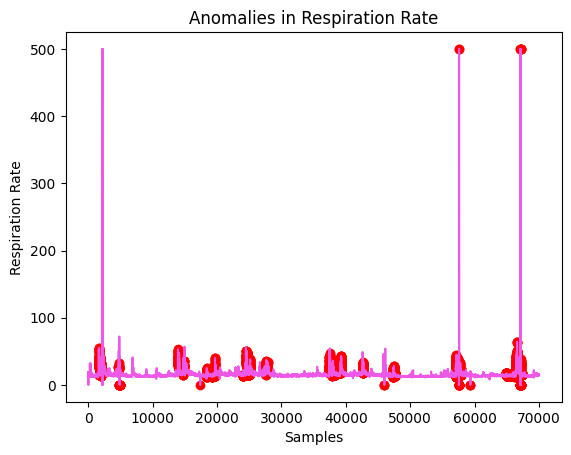

In [ ]:
colors = ['green' if value == 0 else 'red' for value in predictions]
# print(x_test[:,0])
# Plot the line graph
plt.plot(np.array(knn_x[:,3]), color='#ed58e6')

# Add points with different colors
for i in range(knn_x[:,3].shape[0]):
    if(colors[i]=='red'):
      plt.scatter(i,knn_x[:,3][i], color=colors[i])

# Show the plot
plt.xlabel('Samples')
plt.ylabel('Respiration Rate')
plt.title('Anomalies in Respiration Rate')
plt.show()

In [ ]:
colors = ['green' if value == 0 else 'red' for value in predictions]
# print(x_test[:,0])
# Plot the line graph
plt.plot(np.array(knn_x[:,4]), color='#90EE90')
plt.plot(np.array(knn_x[:,5]), color='#c')

# Add points with different colors
for i in range(knn_x[:,4].shape[0]):
    if(colors[i]=='red'):
      plt.scatter(i,knn_x[:,4][i], color=colors[i])
      plt.scatter(i,knn_x[:,5][i], color=colors[i])

# Show the plot
plt.show()

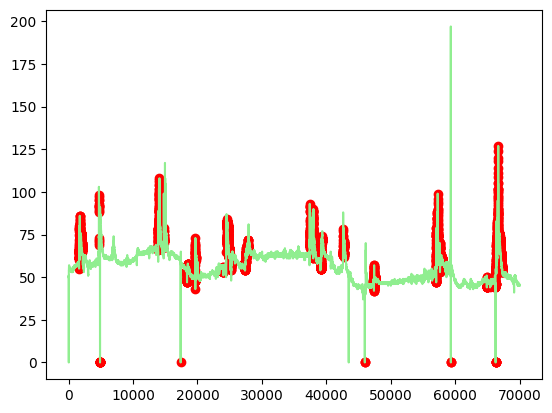

In [ ]:
colors = ['green' if value == 0 else 'red' for value in predictions]
# print(x_test[:,0])
# Plot the line graph
plt.plot(np.array(knn_x[:,5]), color='#90EE90')

# Add points with different colors
for i in range(knn_x[:,5].shape[0]):
    if(colors[i]=='red'):
      plt.scatter(i,knn_x[:,5][i], color=colors[i])

# Show the plot
plt.show()

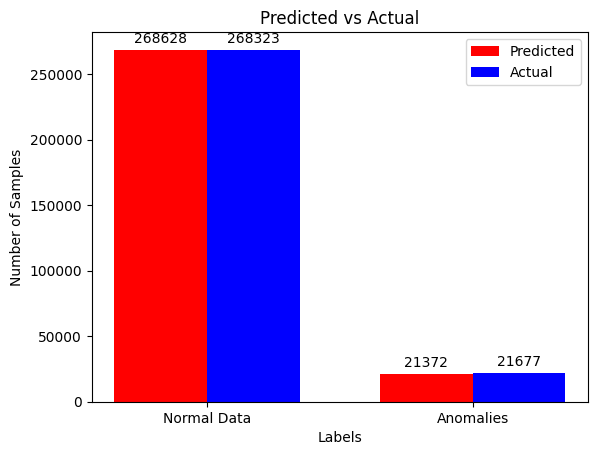

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#243691 244000 N
# 19308 18999 F
# 24632 24628 N
# 2369 2373 F




# Predicted values
actual = [268323, 21677]

# Actual values
predicted = [268628, 21372]

labels = ['Normal Data', 'Anomalies']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

# Plot predicted values in red
rects1 = ax.bar(x - width/2, predicted, width, label='Predicted', color='red')

# Plot actual values in green
rects2 = ax.bar(x + width/2, actual, width, label='Actual', color='b')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Samples')
ax.set_title('Predicted vs Actual')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


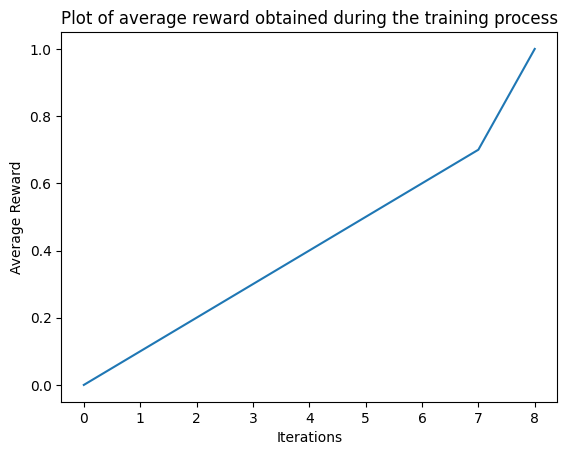

In [ ]:
tr = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,1]
plt.plot(tr)
plt.xlabel('Iterations')
plt.ylabel('Average Reward')
plt.title('Plot of average reward obtained during the training process')
plt.show()